# Import Package & Data

In [1]:
import warnings
warnings.filterwarnings('ignore')
from IPython.display import display

import numpy as np
import pandas as pd
import xgboost as xgb
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import PowerTransformer
from sklearn.preprocessing import StandardScaler

from sklearn import model_selection
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet
from sklearn.tree import DecisionTreeRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split

from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error as mae_score
from sklearn.metrics import mean_absolute_error as rmse_score
from sklearn.metrics import mean_absolute_percentage_error as mape_score

%matplotlib inline
sns.set(rc={'figure.figsize':(20.7,8.27)})
sns.set_style("whitegrid")
sns.color_palette("dark")
plt.style.use("fivethirtyeight")

In [2]:
df=pd.read_csv('housing.csv')
df

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV
0,0.00632,18.0,2.31,0,0.538,6.575,65.2,4.0900,1,296,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0,0.469,6.421,78.9,4.9671,2,242,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0,0.469,7.185,61.1,4.9671,2,242,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0,0.458,6.998,45.8,6.0622,3,222,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0,0.458,7.147,54.2,6.0622,3,222,18.7,396.90,5.33,36.2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
501,0.06263,0.0,11.93,0,0.573,6.593,69.1,2.4786,1,273,21.0,391.99,9.67,22.4
502,0.04527,0.0,11.93,0,0.573,6.120,76.7,2.2875,1,273,21.0,396.90,9.08,20.6
503,0.06076,0.0,11.93,0,0.573,6.976,91.0,2.1675,1,273,21.0,396.90,5.64,23.9
504,0.10959,0.0,11.93,0,0.573,6.794,89.3,2.3889,1,273,21.0,393.45,6.48,22.0


# Prepocessing

## Modeling

## Create Function

In [3]:
def coef_reg(model,x_train):
    '''
    Function to track feature important if the model don't have .important_ module
    '''
    coef_df = pd.DataFrame({'feature':['intercept']+ x_train.columns.tolist()})
    for key,regressor in model.items():
        try:
            if isinstance(list(regressor.coef_)[0], np.ndarray):
                coef_df[key] = [regressor.intercept_] + list(list(regressor.coef_)[0])
            coef_df[key] = [regressor.intercept_] + list(regressor.coef_)
        except:
            continue
    return(coef_df)

def feature_important(model,x_train):
    '''
    function to graph important feature in data frame
    '''
    i=0
    plt.figure(figsize= (15,20))
    for key, regressor in model.items():
        try:
            feature_importances = pd.DataFrame(regressor.feature_importances_,
                                        index = x_train.columns,
                                        columns=['importance']).sort_values('importance', ascending=False)
            i+=1
            plt.subplot(6,3,i)
            sns.barplot(x='importance', y='index', color='#800000',data=feature_importances.reset_index()).set(title=key)
        except:
            continue

def train_regression(x_train,x_test,y_train,y_test) :
    '''
    Function for training several model into a dict
    '''
    regressors = {
        'LinearRegression':LinearRegression(),
        'Lasso':Lasso(),
        'Ridge':Ridge(),
        'ElasticNet':ElasticNet(),
        'RandomForestRegresor':RandomForestRegressor(random_state=1),
        'XGBRegresor':xgb.XGBRegressor(random_state=24)        
                }

    for key , regressor in regressors.items():
        regressor.fit(x_train,y_train)
    display(score(regressors,x_test,y_test))    
    return regressors

def score(model,x_test,y_test):
    '''
    Function for scoring model
    '''
    result_table= pd.DataFrame(columns=['Regressor','MAE', 'RMSE','MAPE', 'R2 Score'])
    for key,regressor in model.items():
        y_pred = regressor.predict(x_test)
        
        #mae,mape,rmse and r2 score
        mae = mae_score(y_test, y_pred)
        mape= mape_score(y_test,y_pred)
        rmse = rmse_score(y_test, y_pred)
        r2 = r2_score(y_test, y_pred)
        
        result_table = result_table.append({'Regressor': key , 
                    'MAE': mae, 
                    'RMSE': rmse,
                    'MAPE': mape,
                    'R2 Score': r2},
                     ignore_index=True)
    return(result_table)

def distribution_plot(df, size = (15, 30)):
  '''
  Function for distplot entire numerical value
  '''
  plt.figure(figsize = size )
  for i in enumerate(df):
      plt.subplot(6, 3,i[0]+1)
      sns.distplot(x=df[[i[1]]], color='blue').set(title=i[1])
      plt.xticks(rotation = 20)
  plt.tight_layout()

def yeojohnTr(df,col):
    '''
    yeojohn transformation
    '''
    yeojohnTr=PowerTransformer(standardize=True)
    df_yeojohn=df.copy()
    for i in col:
        df_yeojohn[i] = yeojohnTr.fit_transform(df[i].values.reshape(-1,1))
    return(df_yeojohn)

def standard(df,col):
    '''
    standard scaller
    '''
    standard=PowerTransformer(standardize=True)
    df_standard=df.copy()
    for i in col:
        df_standard[i] = standard.fit_transform(df[i].values.reshape(-1,1))
    return(df_standard)
    

## Modeling

## Basic Model

,Regressor,MAE,RMSE,MAPE,R2 Score
0,LinearRegression,23.286438,3.21076,0.161118,0.672483
1,Lasso,22.299014,3.189242,0.160458,0.686371
2,Ridge,22.938829,3.109117,0.157075,0.677372
3,ElasticNet,22.083458,3.224316,0.159582,0.689402
4,RandomForestRegresor,16.416357,2.524074,0.130945,0.769109
5,XGBRegresor,9.636894,2.097065,0.110151,0.86446


,Regressor,MAE,RMSE,MAPE,R2 Score
0,LinearRegression,25.102077,3.225382,0.172785,0.657701
1,Lasso,24.538731,3.234243,0.169478,0.665383
2,Ridge,25.211818,3.158403,0.170033,0.656205
3,ElasticNet,23.946298,3.23261,0.168044,0.673462
4,RandomForestRegresor,12.472013,2.267912,0.123353,0.829928
5,XGBRegresor,10.07507,2.136397,0.108013,0.862614


None

,feature,LinearRegression,Lasso,Ridge,ElasticNet
0,intercept,[27.118240409561402],[29.188142215909526],[20.466903287272622],[37.390258572638345]
1,CRIM,-0.106963,-0.066563,-0.101791,-0.085756
2,ZN,0.032806,0.030746,0.036038,0.040722
3,INDUS,0.043696,-0.0,0.00692,-0.013631
4,CHAS,3.007626,0.0,2.63573,0.0
5,NOX,-18.947892,-0.0,-9.373505,-0.0
6,RM,4.957726,2.286992,4.981644,1.408856
7,AGE,-0.002509,0.023834,-0.009153,0.029092
8,DIS,-1.512427,-0.626395,-1.364271,-0.760339
9,RAD,0.220201,0.176576,0.20843,0.245778


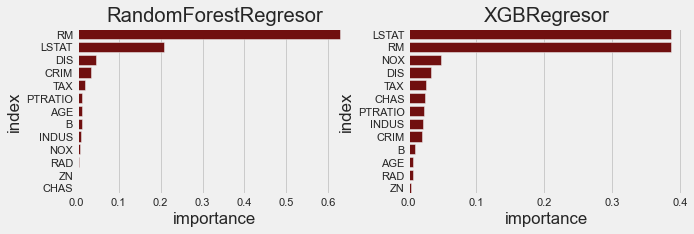

In [4]:
x=df.drop(columns=['MEDV'])
y=df[['MEDV']]

x_train,x_val,y_train,y_val=train_test_split(x,y,
                                                test_size=0.2,
                                                random_state=42)
x_train,x_test,y_train,y_test=train_test_split(x_train,y_train,
                                                  test_size=0.2,
                                                  random_state=42)

model=train_regression(x_train,x_test,y_train,y_test)
display(score(model,x_val,y_val))
display(feature_important(model,x_train),coef_reg(model,x_train))

observation
* XGBoost get the highest score for our model
* `RM` and `LSTAT` are highest importance for XGB and Random Forest
* `PTRATIO` and `LSTAT` highest importance for Lasso alastic Net
* `Nox` and `PTRATIO`highest importance for ridge
* `Nox` was higest importance for Linear Regression 

## Using Transform

,Regressor,MAE,RMSE,MAPE,R2 Score
0,LinearRegression,0.279885,0.371443,1.396839,0.715749
1,Lasso,0.985124,0.743338,1.12691,-0.000492
2,Ridge,0.2793,0.370153,1.373441,0.716343
3,ElasticNet,0.659667,0.5941,1.19157,0.330042
4,RandomForestRegresor,0.188074,0.27867,0.819207,0.808992
5,XGBRegresor,0.146294,0.258723,1.063374,0.851424


Validation Test


,Regressor,MAE,RMSE,MAPE,R2 Score
0,LinearRegression,0.230888,0.322268,1.854747,0.747589
1,Lasso,0.931295,0.69533,1.037558,-0.018111
2,Ridge,0.231299,0.321656,1.845127,0.74714
3,ElasticNet,0.607974,0.539365,0.981002,0.33535
4,RandomForestRegresor,0.168849,0.272646,0.936633,0.815411
5,XGBRegresor,0.125589,0.244432,0.958485,0.862704


None

,feature,LinearRegression,Lasso,Ridge,ElasticNet
0,intercept,[-0.016860326613681195],[0.022423568154442703],[-0.016842628169111428],[0.01624587363600479]
1,CRIM,0.063629,-0.0,0.060437,-0.0
2,ZN,0.009919,0.0,0.009341,0.0
3,INDUS,-0.040439,-0.0,-0.041099,-0.0
4,CHAS,0.072552,0.0,0.072856,0.0
5,NOX,-0.185428,-0.0,-0.179201,-0.0
6,RM,0.14432,0.0,0.146655,0.025194
7,AGE,0.029489,-0.0,0.028317,-0.0
8,DIS,-0.274048,0.0,-0.268537,0.0
9,RAD,0.05817,-0.0,0.056858,-0.0


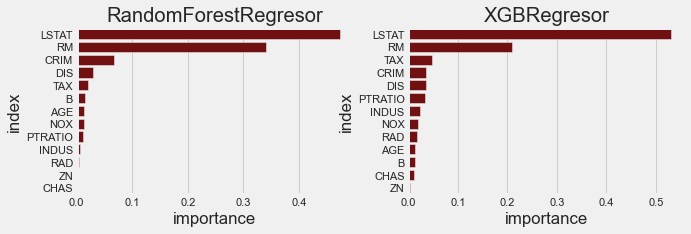

In [5]:
#transform feature with YeoJohn Transformation
col=df[:-1]
dft=yeojohnTr(df,col)
dft=standard(dft,col)

#define feature and target
xt=dft.drop(columns=['MEDV'])
yt=dft[['MEDV']]

#split data into validation, train and test data set
xt_train,xt_val,yt_train,yt_val=train_test_split(xt,yt,
                                                test_size=0.2,
                                                random_state=42)

xt_train,xt_test,yt_train,yt_test=train_test_split(xt_train,yt_train,
                                                  test_size=0.2,
                                                  random_state=42)

#train model
modelt=train_regression(xt_train,xt_test,yt_train,yt_test)
print('Validation Test')
display(score(modelt,xt_val,yt_val))
display(feature_important(modelt,xt_train),coef_reg(modelt,xt_train))

## Drop Multicollinearity Feature

,Regressor,MAE,RMSE,MAPE,R2 Score
0,LinearRegression,24.622923,3.244694,0.162277,0.653686
1,Lasso,23.48232,3.269335,0.163918,0.669728
2,Ridge,24.131196,3.139843,0.158027,0.660602
3,ElasticNet,23.596493,3.358693,0.165685,0.668122
4,RandomForestRegresor,17.578923,2.592049,0.133368,0.752757
5,XGBRegresor,11.07024,2.27256,0.117648,0.8443


,Regressor,MAE,RMSE,MAPE,R2 Score
0,LinearRegression,26.976886,3.352841,0.181401,0.632136
1,Lasso,26.270691,3.398051,0.178566,0.641766
2,Ridge,26.858725,3.264556,0.177237,0.633747
3,ElasticNet,25.815498,3.389427,0.176676,0.647973
4,RandomForestRegresor,12.66717,2.30151,0.124398,0.827267
5,XGBRegresor,9.714749,2.099272,0.102787,0.867527


None

,feature,LinearRegression,Lasso,Ridge,ElasticNet
0,intercept,[22.82877362128445],[25.823434864217262],[16.790077398166723],[34.74560819929827]
1,CRIM,-0.076956,-0.041076,-0.073607,-0.053307
2,ZN,0.025653,0.025273,0.029092,0.032528
3,INDUS,-0.005538,-0.0,-0.037819,-0.06337
4,CHAS,3.299622,0.0,2.912995,0.0
5,NOX,-17.872107,-0.0,-8.863465,-0.0
6,RM,5.168419,2.504122,5.175816,1.493287
7,AGE,-0.004688,0.022055,-0.010808,0.029085
8,DIS,-1.509215,-0.599362,-1.36937,-0.776003
9,TAX,0.000791,-0.002994,-0.000856,-0.001886


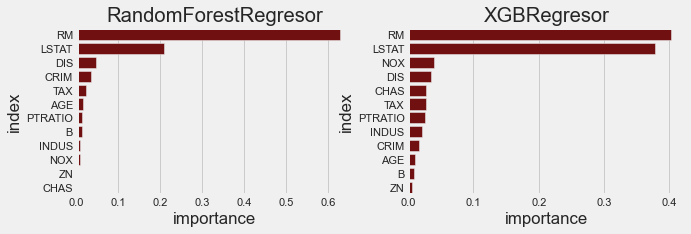

In [6]:
df_drop=df.drop(columns='RAD')

x_drop=df_drop.drop(columns='MEDV')
y_drop=df_drop[['MEDV']]

x_drop_train,x_drop_val,y_drop_train,y_drop_val=train_test_split(x_drop,y_drop,
                                                test_size=0.2,
                                                random_state=42)
x_drop_train,x_drop_test,y_drop_train,y_drop_test=train_test_split(x_drop_train,y_drop_train,
                                                test_size=0.2,
                                                random_state=42)

model_drop=train_regression(x_drop_train,x_drop_test,y_drop_train,y_drop_test)
display(score(model_drop,x_drop_val,y_drop_val))
display(feature_important(model_drop,x_drop_train),coef_reg(model_drop,x_drop_train))


Observation
* all of our model got score decrease than whitout droping `RAD`
* even thought vif score is 9, droping our value decrese all model overall score.
* There is not any significant effect with XGBoost and Random forest with multicollinearity handling, just like any decision trees model which are insensitive againts multicollinearity.


Conclusion
* XGBoost Regressor are the best model, next step will be optimeze it using parameter
* Multicollinearity and Transformation reduce XGB perfomance, the data I'm using still the original one

## Hyperparameter Tuning

Default Parameter for XGBoost Regressor <br>

| Parameter      | Default| 
| :---           | ---:   | 
| n_estimators   | 100    |          
| max_depth      | 6      | 
| learning _rate | 0.3    | 
|colsample_bytree| 1      |
|subsample       | 1      |





In [7]:
dmatrix = xgb.DMatrix(data=x_train, label=y_train) #Learning API uses a dmatrixparams = {'objective':'reg:squarederror'}
params = {'objective':'reg:squarederror'}
cv_results = xgb.cv(dtrain=dmatrix, 
                    params=params, 
                    nfold=10, 
                    metrics={'rmse'})
                    
print('RMSE: %.2f' % cv_results['test-rmse-mean'].min())

RMSE: 3.69


In [8]:
cv_results

,train-rmse-mean,train-rmse-std,test-rmse-mean,test-rmse-std
0,17.403337,0.115785,17.392393,1.080408
1,12.626434,0.087660,12.672282,0.930706
2,9.259520,0.068327,9.504387,0.962062
3,6.865646,0.051238,7.359139,1.023137
4,5.174518,0.046237,5.872896,1.072462
5,3.962345,0.036810,4.871502,0.947918
6,3.095930,0.038894,4.338209,0.916258
7,2.486817,0.046255,4.018308,0.891749
8,2.048539,0.052474,3.816240,0.900877
9,1.728139,0.047417,3.689393,0.880355


In [9]:
xgbr = xgb.XGBRegressor(objective='reg:squarederror')
xgbr.fit(x_train, y_train)
 
y_pred = xgbr.predict(x_test)
rmse = rmse_score(y_test, y_pred)
print("RMSE: %.2f" % rmse)

RMSE: 2.10


In [10]:
y_pred=xgbr.predict(x_test)

rmse_score(y_test,y_pred)
r2_score(y_test,y_pred)

0.8644597968962042

In [11]:
params = { 'max_depth': [3, 5, 6, 8 ,10, 15, 20],
           'learning_rate': [0.01, 0.1, 0.2, 0.3, 0.5],
           'n_estimators': [100, 500, 1000]}
xgbr = xgb.XGBRegressor()
clf = GridSearchCV(estimator=xgbr, 
                   param_grid=params,
                   scoring='r2', 
                   verbose=1)
clf.fit(x_train, y_train)
print("Best parameters:", clf.best_params_)
print("r2: ", clf.best_score_)
xgboost1={'xgboost':clf.best_estimator_}
hasil=score(xgboost1,x_test,y_test)

Fitting 5 folds for each of 105 candidates, totalling 525 fits
Best parameters: {'learning_rate': 0.01, 'max_depth': 6, 'n_estimators': 1000}
r2:  0.8497759635269659


In [12]:
# test 2
params = { 'subsample': np.arange(0.5, 1.0, 0.1),
           'colsample_bytree': np.arange(0.4, 1.0, 0.1),
           'colsample_bylevel': np.arange(0.4, 1.0, 0.1),
           }
xgbr = xgb.XGBRegressor(n_estimators = 1000,
                        max_depth = 6,
                        learning_rate = 0.01
                        )
clf = GridSearchCV(estimator=xgbr, 
                   param_grid=params,
                   scoring='r2',
                   verbose=1)
clf.fit(x_train, y_train)
print("Best parameters:", clf.best_params_)
print("r2: ", clf.best_score_)
xgboost2={'xgboost2':clf.best_estimator_}
hasil2=score(xgboost2,x_test,y_test)

Fitting 5 folds for each of 180 candidates, totalling 900 fits
Best parameters: {'colsample_bylevel': 0.4, 'colsample_bytree': 0.7, 'subsample': 0.8999999999999999}
r2:  0.8554774621807029


In [13]:
params = { 'subsample': np.arange(0.5, 1.0, 0.1),
           'colsample_bytree': np.arange(0.4, 1.0, 0.1),
           'colsample_bylevel': np.arange(0.4, 1.0, 0.1),
           }
xgbr = xgb.XGBRegressor(n_estimators = 1000,
                        max_depth = 6,
                        learning_rate = 0.01
                        )
clf = GridSearchCV(estimator=xgbr, 
                   param_grid=params,
                   scoring='r2', 
                   verbose=1)
clf.fit(x_train, y_train)
print("Best parameters:", clf.best_params_)
print("r2:", clf.best_score_)
xgboost2={'xgboost2':clf.best_estimator_}
hasil2=score(xgboost2,x_test,y_test)

Fitting 5 folds for each of 180 candidates, totalling 900 fits
Best parameters: {'colsample_bylevel': 0.4, 'colsample_bytree': 0.7, 'subsample': 0.8999999999999999}
r2: 0.8554774621807029


In [14]:
hasil=hasil.append(hasil2,ignore_index=True)
hasil

,Regressor,MAE,RMSE,MAPE,R2 Score
0,xgboost,9.442718,1.988843,0.106375,0.867191
1,xgboost2,9.477149,1.921012,0.102283,0.866707


# Conclussion

**Model**
* Normalized and standarized increase linear regression and ridge regression score, while lasso get rid all features while only maintaining intercept. the cause Lasso selects only the significant variables in the model but after transformed feature has a small number and near each other and for elastic net have same behavior as lasso but still able pick `RM` as a feature because it is the most significant feature than the rest.
* Tree base model such as XGB and random forest have better result than other model, because most of our value dont have high correlation to our target.
* There is multicolinearity in data but droping it got worse result in all model for both test data and unseen data.



**XGB Model Performance**<br>
* Data not standarized or normalized, with experiment above Xgb model got better result. xgb model is a tree base model so it can handle outliner really well .<br><br>
* There is multicolinearity in data but XGB is tree based model therefore it is insensitive againts Multicollinearity.<br><br>
* sucessfully tune XGB model, even thought R2 Validation Score smaller than first tune, rmse smaller and still better than basic model. 
